Testovací kod sapce pro thetu

In [ ]:
import io
import copy
import random
import contextlib
import numpy as np
import matplotlib.pyplot as plt

from UQpy.distributions import Uniform, JointIndependent
from UQpy.sampling import ThetaCriterionPCE
import SAPCE


In [ ]:
def truth_model(X): # model pro porovnání - hodnoty jsou SKUTEČNÉ
    x1 = X[:, 0]
    x2 = X[:, 1]
    y1 = x1**2 + 0.5 * x2**2
    y2 = x1 * x2 + 0.2 * np.sin(3.0 * x1)
    return np.column_stack([y1, y2])

def pce_to_list(pce_multi):     # fUNKCE sapce na pce list
 
    C = np.asarray(pce_multi.coefficients)
    if C.ndim == 1:
        C = C.reshape(-1, 1)

    seznam = []
    for j in range(C.shape[1]):
        p = copy.deepcopy(pce_multi)
        p.coefficients = C[:, j].reshape(-1, 1)
        seznam.append(p)
    return seznam

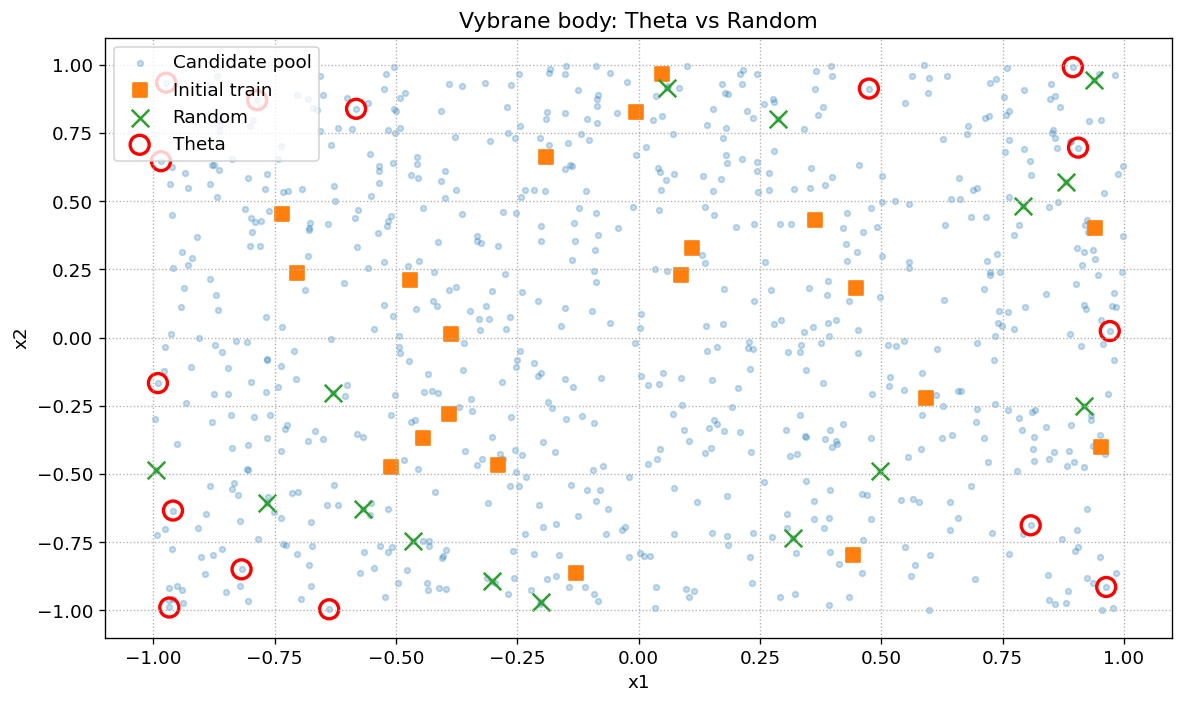

In [112]:

## Zaklad
np.random.seed(0)
random.seed(0)

joint = JointIndependent(marginals=[
    Uniform(loc=-1, scale=2),
    Uniform(loc=-1, scale=2)
])

def truth_model(X): # model pro porovnání - hodnoty jsou SKUTEČNÉ
    x1 = X[:, 0]
    x2 = X[:, 1]
    y1 = x1**2 + 0.5 * x2**2
    y2 = x1 * x2 + 0.2 * np.sin(3.0 * x1)
    return np.column_stack([y1, y2])

def pce_to_list(pce_multi):     # fUNKCE sapce na pce list
 
    C = np.asarray(pce_multi.coefficients)
    if C.ndim == 1:
        C = C.reshape(-1, 1)

    seznam = []
    for j in range(C.shape[1]):
        p = copy.deepcopy(pce_multi)
        p.coefficients = C[:, j].reshape(-1, 1)
        seznam.append(p)
    return seznam


## Práce s daty
pool = joint.rvs(nsamples=800) #vygeneruji si kandidatni body
pocet_start = 20 # pocet bodu na zacatku (s cim Theta zacina)
start_idx = np.random.choice(np.arange(pool.shape[0]), size=pocet_start, replace=False)
x_start = pool[start_idx]
y_start = truth_model(x_start)
maska = np.ones(pool.shape[0], dtype=bool) # aby theta nebrala znovu ty body se ktrými se začíná
maska[start_idx] = False
cand_theta = pool[maska].copy()
cand_rand  = pool[maska].copy()


# THETA vs RANDOM
K = 15
theta_body = []
x_theta = x_start.copy()
y_theta = y_start.copy()

for k in range(K):

    #sapce
    sapce = SAPCE.SensitivityAdaptivePCE(
        pdf=joint,
        exp_design_in=x_theta,
        exp_design_out=y_theta,
        max_partial_degree=8,
        num_inputs=2
    )

    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        sapce.construct_adaptive_basis(max_condition_number=1e8)
        sapce.construct_pruned_pce(cr=0.01)

    # rozdelim sapce
    pce_list = pce_to_list(sapce.pce)

    # Theta vybere kandidata
    theta = ThetaCriterionPCE(pce_list)
    i = int(theta.run(x_theta, cand_theta))
    novy_x = cand_theta[i]
    novy_y = truth_model(novy_x.reshape(1, -1))

    theta_body.append(novy_x)
    x_theta = np.vstack([x_theta, novy_x])
    y_theta = np.vstack([y_theta, novy_y])
    #  odebere vybrany bod z kandidatu
    cand_theta = np.delete(cand_theta, i, axis=0)

theta_body = np.array(theta_body)



# Random vyber (bez iteraci) 
rand_idx = np.random.choice(np.arange(cand_rand.shape[0]), size=K, replace=False)
rand_body = cand_rand[rand_idx]


# Vykresleni vybranych bodu

plt.figure(figsize=(10, 6), dpi=120)
plt.scatter(pool[:, 0], pool[:, 1], s=12, alpha=0.25, label="Candidate pool")
plt.scatter(x_start[:, 0], x_start[:, 1], s=70, marker="s", label="Initial train")
plt.scatter(rand_body[:, 0], rand_body[:, 1], s=110, marker="x", label="Random")
plt.scatter(theta_body[:, 0], theta_body[:, 1], s=130, facecolors="none",
            edgecolors="red", linewidth=2, marker="o", label="Theta")
plt.title("Vybrane body: Theta vs Random")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()


Test 2: pravda vs random vs theta

Theta : OK (deg=6, cr=0.001)
Random: OK (deg=6, cr=0.001)
Theta RMSE : 0.0004401754739591486
Random RMSE: 0.0014288674784732906


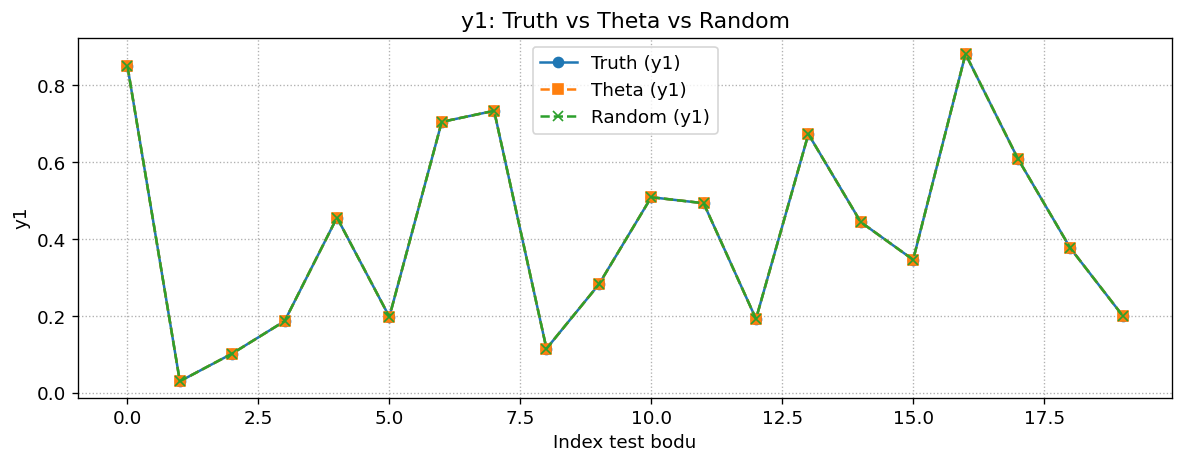

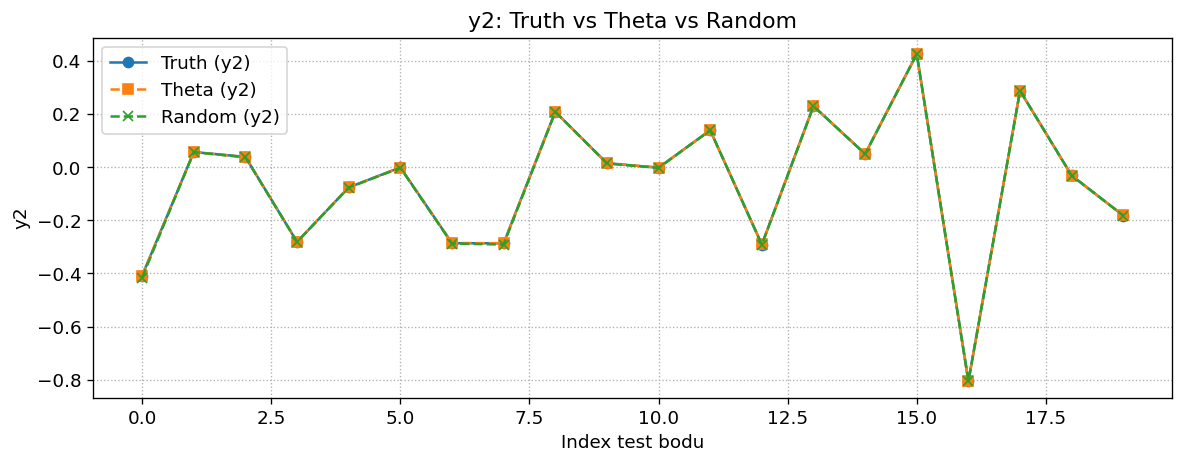

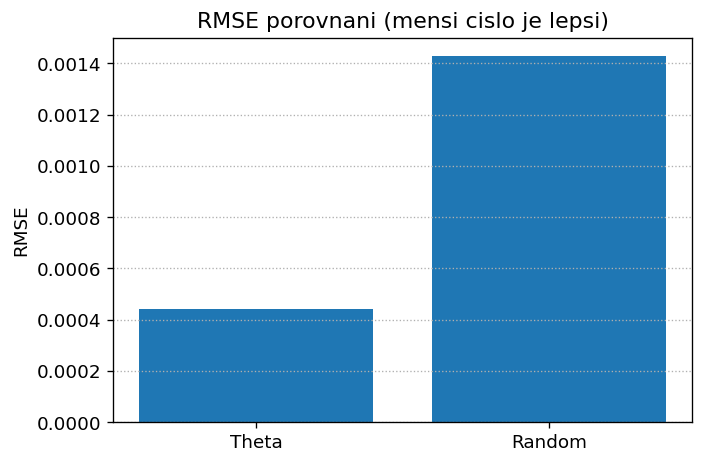

In [142]:
# Sestavim random
y_rand_body = truth_model(rand_body)
x_rand = np.vstack([x_start, rand_body])
y_rand = np.vstack([y_start, y_rand_body])

# Sestavím Sapce Theta
deg = 6
cr  = 0.001

sapce_t = SAPCE.SensitivityAdaptivePCE(
    pdf=joint,
    exp_design_in=x_theta,
    exp_design_out=y_theta,
    max_partial_degree=deg,
    num_inputs=2
)

with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    sapce_t.construct_adaptive_basis(max_condition_number=1e6)
    sapce_t.construct_pruned_pce(cr=cr)

pce_theta = pce_to_list(sapce_t.pce)
theta_info = f"OK (deg={deg}, cr={cr})"

# Sapce random
sapce_r = SAPCE.SensitivityAdaptivePCE(
    pdf=joint,
    exp_design_in=x_rand,
    exp_design_out=y_rand,
    max_partial_degree=deg,
    num_inputs=2
)
with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
    sapce_r.construct_adaptive_basis(max_condition_number=1e6)
    sapce_r.construct_pruned_pce(cr=cr)

pce_rand = pce_to_list(sapce_r.pce)
rand_info = f"OK (deg={deg}, cr={cr})"

print("Theta :", theta_info)
print("Random:", rand_info)

# Test
n_test = 20
test_x = joint.rvs(nsamples=n_test)
pravda = truth_model(test_x)

# Predikce
def predikuj(pce_list, X):
    out = []
    for p in pce_list:    # projdeme kazdou PCE zvlast
        y = None
        for m in ("predict", "evaluate", "__call__", "run"):  #názvy metod v Pythonu, nejspíš má každý PCE jiný
            if hasattr(p, m):
                y = np.asarray(getattr(p, m)(X))
                break
              
        if y.ndim == 1:   # Pro 1D
            y = y.reshape(-1, 1)
        out.append(y)
    return np.hstack(out) # z listu sloupcu udelam jednu matici (n, 2)

theta_pred = predikuj(pce_theta, test_x)     
rand_pred  = predikuj(pce_rand,  test_x)

rmse_theta = float(np.sqrt(np.mean((theta_pred - pravda) ** 2)))
rmse_rand  = float(np.sqrt(np.mean((rand_pred  - pravda) ** 2)))


print("Theta RMSE :", rmse_theta)
print("Random RMSE:", rmse_rand)


# Grafy
idx = np.arange(n_test)

# Y1
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(idx, pravda[:, 0], marker="o", linestyle="-", label="Truth (y1)")
plt.plot(idx, theta_pred[:, 0], marker="s", linestyle="--", label="Theta (y1)")
plt.plot(idx, rand_pred[:, 0], marker="x", linestyle="--", label="Random (y1)")
plt.title("y1: Truth vs Theta vs Random")
plt.xlabel("Index test bodu")
plt.ylabel("y1")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# Y2
plt.figure(figsize=(10, 4), dpi=120)
plt.plot(idx, pravda[:, 1], marker="o", linestyle="-", label="Truth (y2)")
plt.plot(idx, theta_pred[:, 1], marker="s", linestyle="--", label="Theta (y2)")
plt.plot(idx, rand_pred[:, 1], marker="x", linestyle="--", label="Random (y2)")
plt.title("y2: Truth vs Theta vs Random")
plt.xlabel("Index test bodu")
plt.ylabel("y2")
plt.grid(True, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

# RMSE porovnani
plt.figure(figsize=(6, 4), dpi=120)
plt.bar(["Theta", "Random"], [rmse_theta, rmse_rand])
plt.title("RMSE porovnani (mensi cislo je lepsi)")
plt.ylabel("RMSE")
plt.grid(True, axis="y", linestyle=":")
plt.tight_layout()
plt.show()
